Q7:

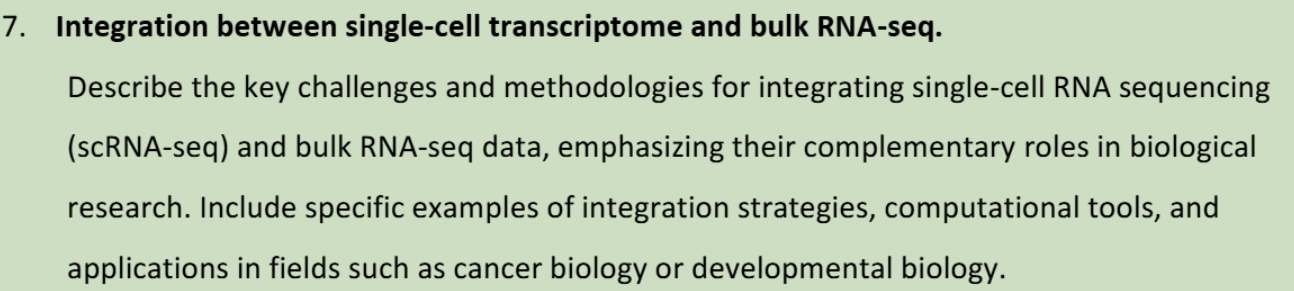

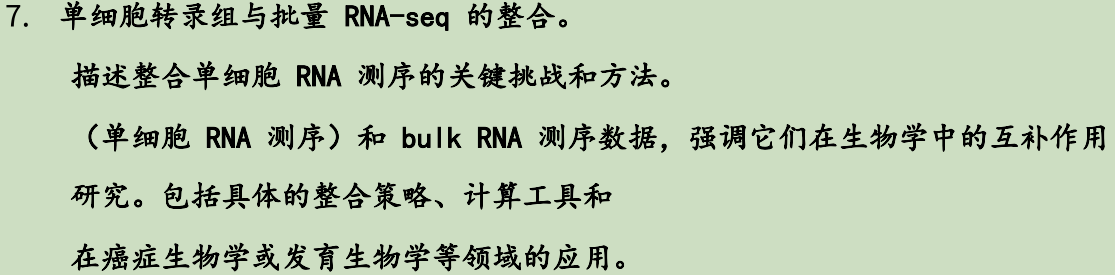

Bulk RNA-seq  和 single cell RNA-seq 的主要区别在于单细胞测序代表单个细胞（single cell），而 bulk 测序代表一群细胞（a population of cells）。我们都知道单细胞转录组测序能够解决常规转录组测序无法解决的细胞异质性问题，现在很多的研究同时进行 Bulk RNA-seq  和 single cell RNA-seq，为了明确单细胞测序分析结果的准确性，可以利用相同样本的  Bulk RNA-Seq  数据进行评估，两种测序结果相互印证

1，关键挑战与方法

| 挑战         | 方法           | 工具                     |
|--------------|----------------|--------------------------|
| 分辨率差异   | 细胞类型反卷积 | CIBERSORTx, MuSiC        |
| 批次效应     | 锚点整合       | Harmony, Seurat          |
| 数据稀疏性   | 插值降噪       | MAGIC, DCA               |

主要还是批次效应：

样本数据整合中的批次效应，

批次效应

批次效应是测量的表达水平的变化，这是处理不同组或“批次”中的细胞的结果。例如，如果两个实验室从同一队列中采集样本，但这些样本的解离方式不同，则可能会出现批次效应。如果实验室 A 优化其解离方案以解离样品中的细胞，同时最大限度地减少对细胞的压力，而实验室 B 没有这样做，那么 B 组数据中的细胞很可能会表达更多与压力相关的基因。

一般来说，批次效应的来源多种多样且难以确定。一些批次效应来源可能是技术性的，例如样品处理、实验方案或测序深度的差异，但供体变异、组织或采样位置等生物效应也可以被解释为批次效应。是否应考虑生物因素带来的批次效应取决于实验设计和所提出的问题。例如我们在探究肿瘤与性别的关系的时候，那么性别就应当保留，而不是当成批次效应去除。

在scRNA-seq中，消除批次效应往往由以下三个步骤构成：

* 降维
* 建模并消除批次效应
* 嵌入

scRNA-seq中常见的降维方法无非就3种，PCA、t-SNE以及UMAP

绝大多数的批次效应校正算法都包括了如何构建一个稳定的数学模型，大致可以分为四类：全局模型，线性嵌入模型，基于图的模型，深度学习模型

* 全局模型: 源自bulk RNA-seq，将批次效应建模为所有细胞中存在的（加法/或乘法）效应。一个常见的例子是 ComBat
* 线性嵌入模型: 是第一个单细胞特异性批次去除方法。这些方法通常使用奇异值分解 (SVD) 的变体来嵌入数据，然后在嵌入中跨批次查找相似单元的局部邻域，并使用它们以局部自适应（非线性）方式校正批次效应。常见的例子包括最近邻MNN，Seurat，Harmony，Scanorama，FastMNN等
* 基于图的模型: 通常是运行速度最快的方法。使用最近邻域图来表示每个批次的数据。通过强制连接不同批次的细胞，然后修建细胞类型组成的差异的图的边缘，可以纠正批次效应。一个常见的例子是BBKNN
* 深度学习模型: 大多数深度学习批次效应校正方法都基于自动编码器网络，并且要么在条件变分自动编码器（CVAE）中对批量协变量进行降维，要么在嵌入空间中拟合局部线性校正。

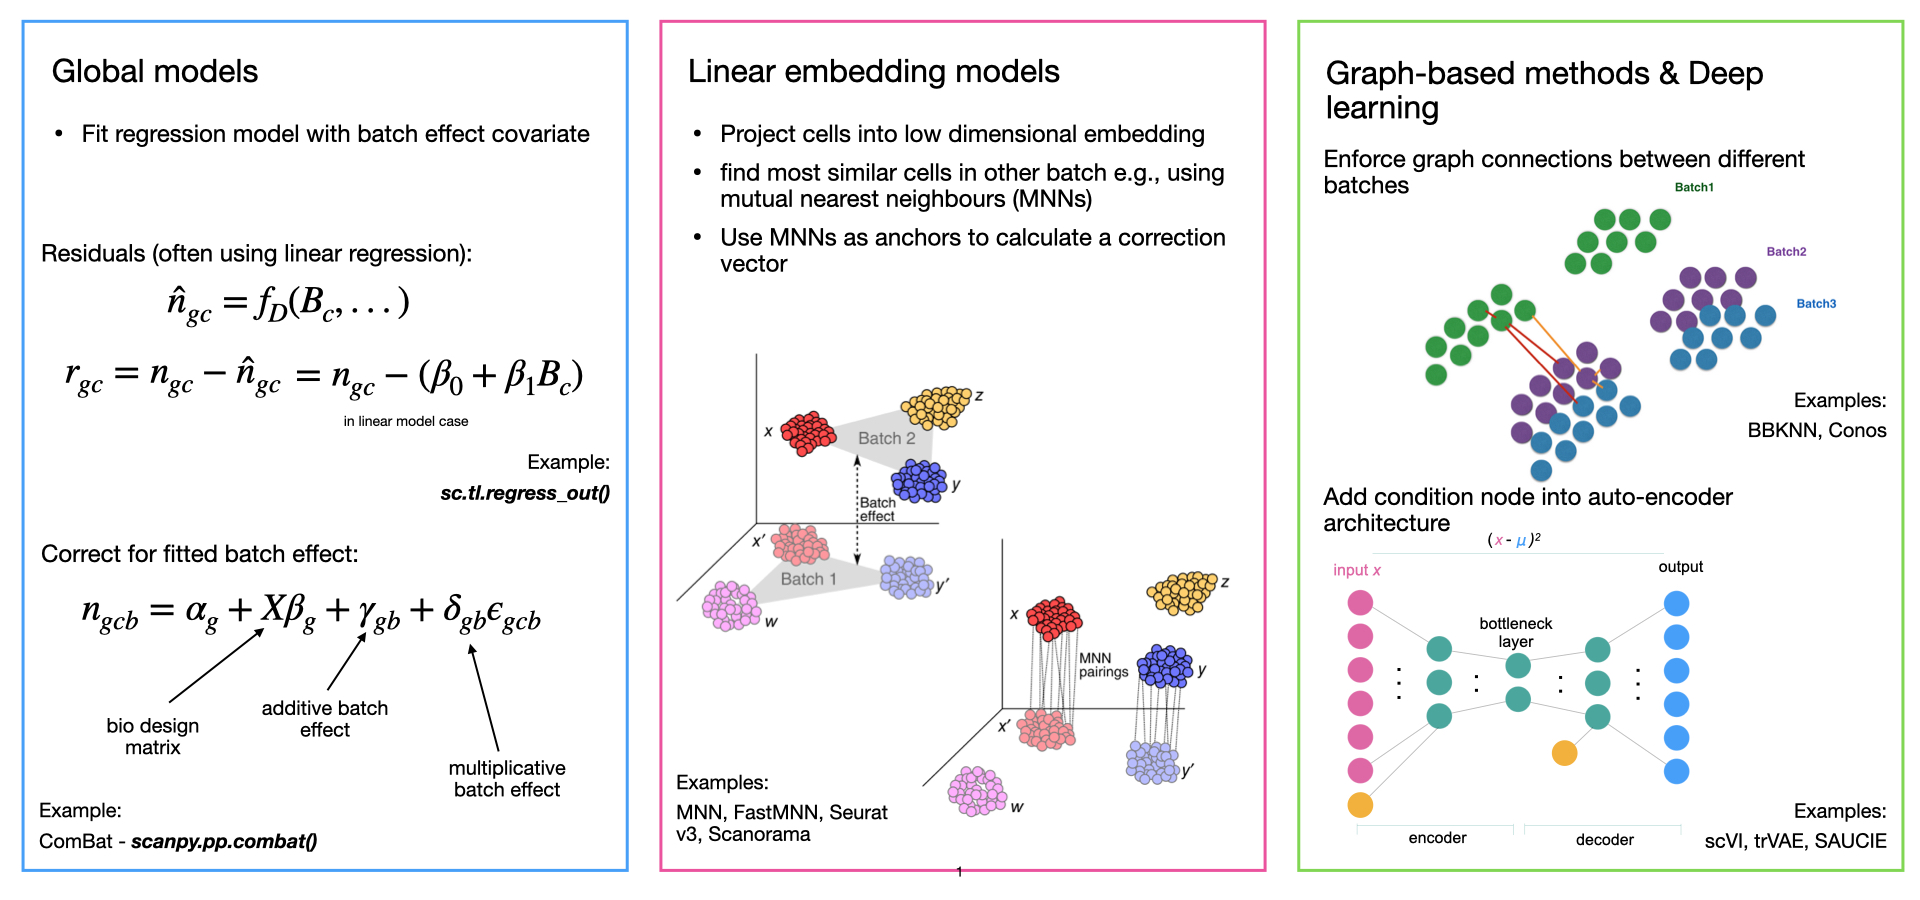

有相关的benchmark研究：

用scib包，比较不同批次效应矫正算法

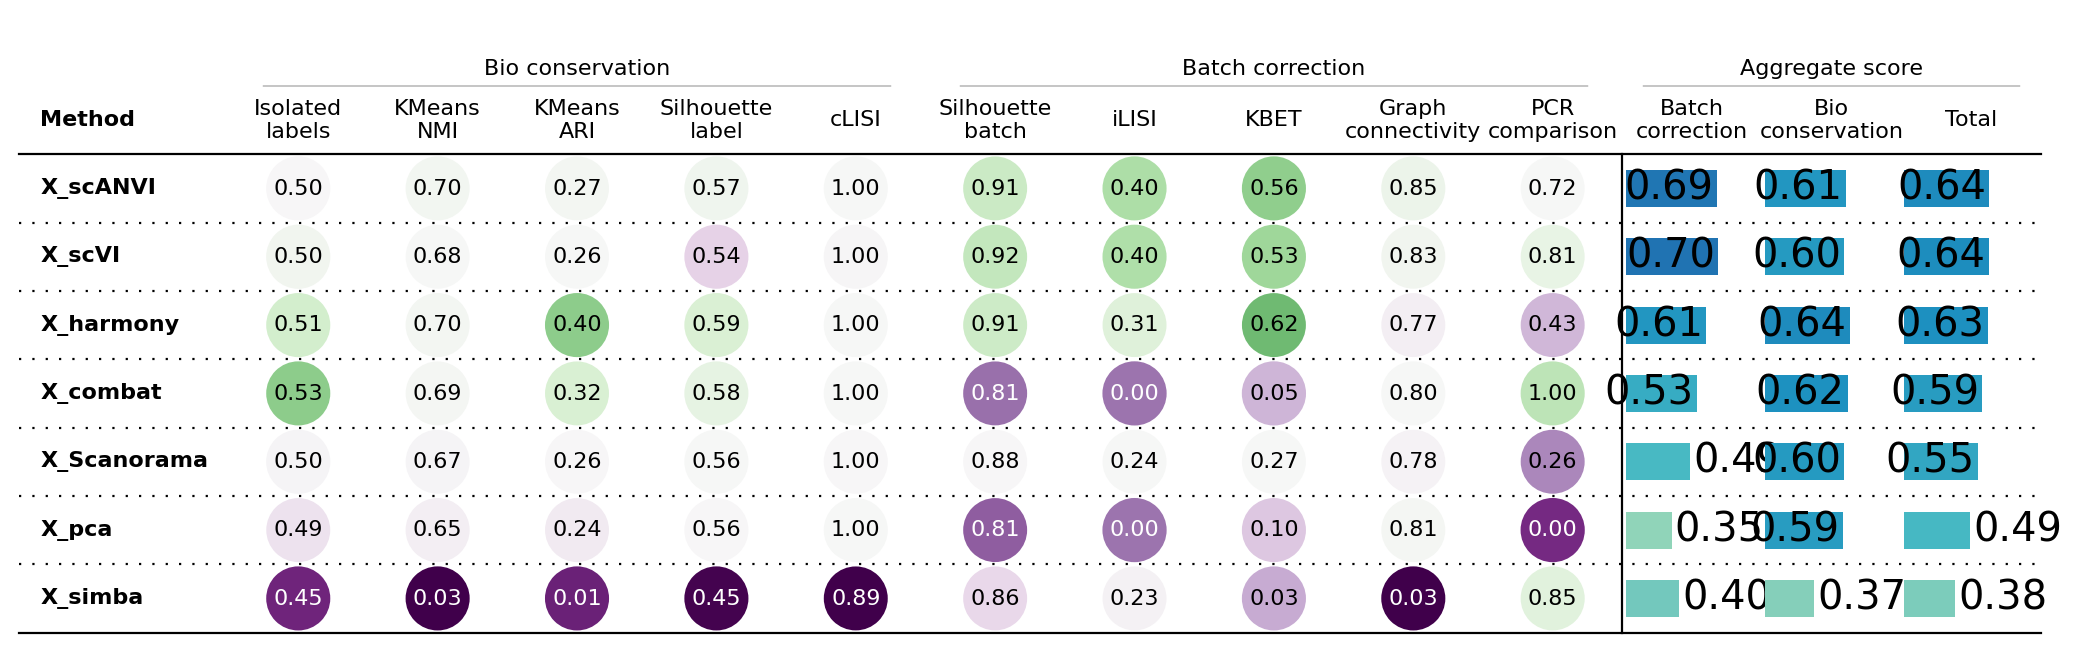

以上figure参考：https://single-cell-tutorial.readthedocs.io/zh/latest/preprocess/2-5/

2，具体应用举例

具体的整合策略、计算工具、实际应用

（1）参考：https://www.nature.com/articles/s41598-024-62913-3

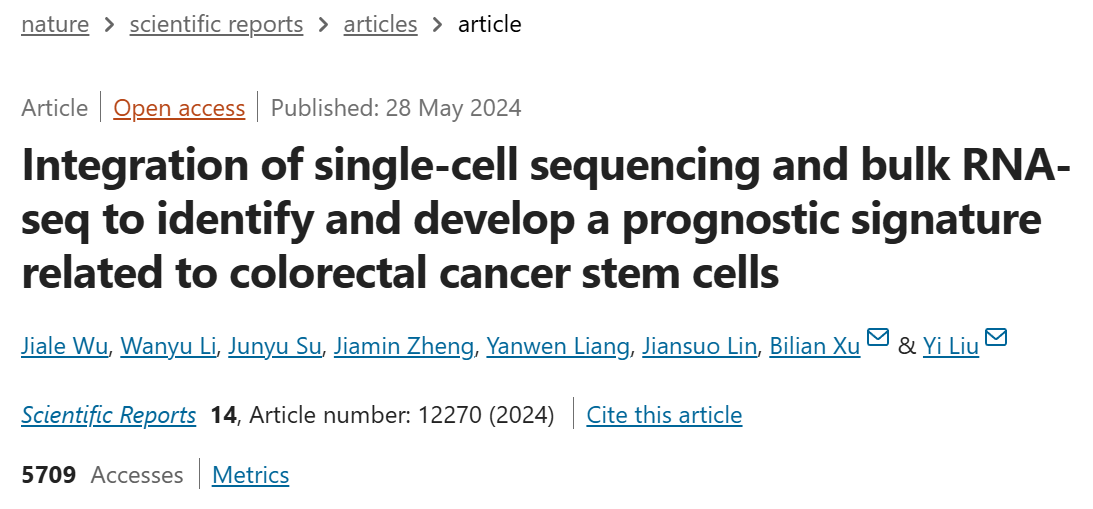

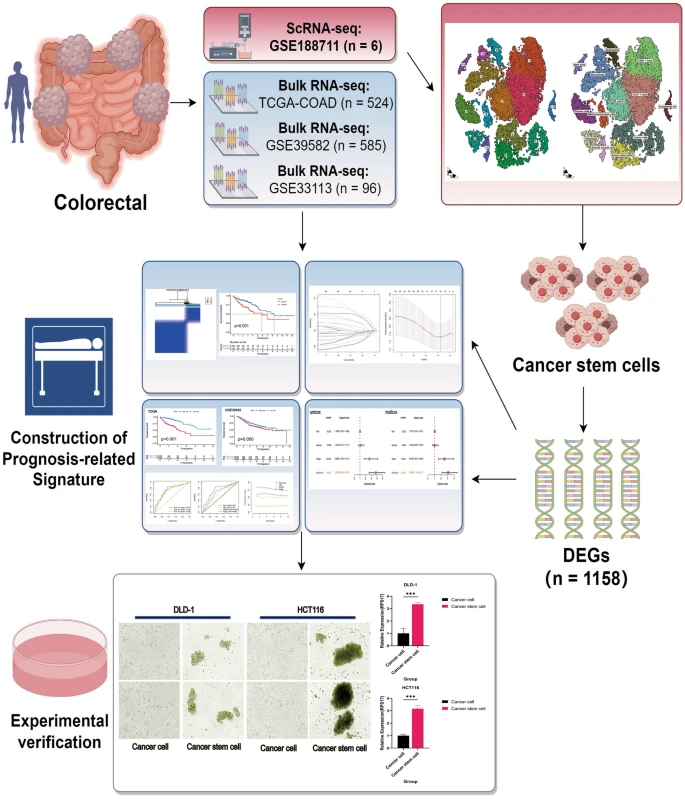

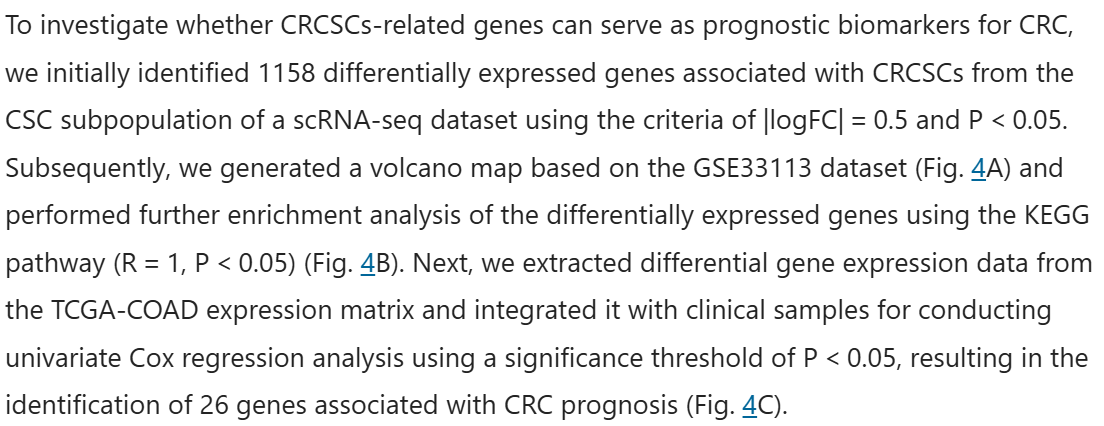

应用层面上的整合：

scRNA-seq，用来区分结直肠癌微环境中的癌细胞干细胞（CSCs）并分析其单细胞水平的特性，主要是找gene

bulk RNA-seq，是利用 TCGA 和 GEO 数据库的数据，构建了 CRCSCs 相关gene的预后风险模型，并验证了其诊断性能，还研究了风险模型中相关基因的功能富集、免疫反应及化疗药物敏感性

主要是1个找gene，另外一个bulk层面上应用这些gene去构建风险预测model，只是对象进行层层组学筛选，并没有方法、工具上信息的并行整合交互，是串行的

为探究 CRCSCs 相关基因是否可作为 CRC 的预后生物标志物，

我们首先使用|logFC|=0.5 和 P<0.05 的标准，从 scRNA-seq 数据集的 CSC 亚群中鉴定出与 CRCSCs 相关的 1158 个差异表达基因。

随后，我们基于 GSE33113 数据集生成了火山图，并对差异表达基因进行了 KEGG 通路富集分析（R=1，P<0.05）。

接下来，我们从 TCGA-COAD 表达矩阵中提取差异基因表达数据，并与临床样本整合，采用 P<0.05 的显著性阈值进行单因素 Cox 回归分析，最终鉴定出 26 个与 CRC 预后相关的基因

| **项目**         | **内容**                                                                 |
|:-----------------|:-------------------------------------------------------------------------|
| **整合策略**     | 1. **数据预处理**：使用“limma”和“SVA”R包对TCGA和GEO数据进行预处理，以减少技术误差和批次效应。GEO数据进行了log2(X+1)转换，仅保留TCGA和GEO数据集中共有的基因，通过“Combat”函数进一步校正批次效应。  <br> 2. **单细胞数据质量控制**：使用“Seurat”R包构建S4对象，并通过“Harmony”R包整合多个样本的数据。设置质量控制条件，如基因表达细胞数、基因计数范围、线粒体基因比例等，以确保数据质量。  <br> 3. **细胞类型鉴定与标记基因筛选**：通过单细胞数据识别细胞亚群和标记基因，结合已知的细胞类型标记基因（如CSCs、癌细胞、免疫细胞等）来鉴定不同细胞类型。  <br> 4. **差异基因分析与功能富集**：利用单细胞数据筛选与CRCSCs相关的差异表达基因，并结合bulk RNA-seq数据进行功能富集分析，以确定关键的生物学过程和信号通路。  <br> 5. **风险模型构建与验证**：基于单细胞和bulk RNA-seq数据筛选的差异基因，构建Lasso-Cox回归风险模型，并在TCGA和GEO数据集中进行训练和验证。 |
| **计算工具**     | 1. **数据预处理**：R包“limma”、“SVA”、“Combat”  <br> 2. **单细胞数据分析**：R包“Seurat”、“Harmony”  <br> 3. **细胞通信分析**：R包“CellChat”、“NMF”  <br> 4. **细胞轨迹分析**：R包“monocle”  <br> 5. **代谢功能分析**：R包“scMetabolism”、“AUcell”  <br> 6. **风险模型构建**：R包“glmnet”、“Survival”、“timeROC”、“Regplot”  <br> 7. **功能富集分析**：R包“org.Hs.eg.db”、“clusterProfiler”、“enrichplot”  <br> 8. **免疫相关分析**：R包“TIDE”、“ssGSEA”、“CIBERSORT”  <br> 9. **药物敏感性分析**：R包“pRRophetic” |
| **应用场景**     | 1. **细胞类型鉴定**：通过单细胞数据识别CRC微环境中的细胞亚群，包括CSCs、癌细胞、免疫细胞等。  <br> 2. **细胞通信分析**：分析CRCSCs与其他细胞类型（如癌细胞、免疫细胞）之间的通信网络，揭示它们在肿瘤微环境中的相互作用。  <br> 3. **细胞代谢功能分析**：评估不同细胞类型在肿瘤微环境中的代谢活动，识别与CRCSCs相关的代谢通路。  <br> 4. **风险模型构建与验证**：基于单细胞和bulk RNA-seq数据筛选的差异基因，构建风险模型以预测CRC患者的预后，并在TCGA和GEO数据集中进行验证。  <br> 5. **免疫相关分析**：评估风险模型与免疫功能的相关性，分析高风险和低风险患者的免疫细胞浸润差异。  <br> 6. **药物敏感性分析**：预测不同风险组患者对化疗药物的敏感性，为临床化疗方案的选择提供参考。 |

（2）https://www.dovepress.com/integration-of-single-cell-and-bulk-rna-sequencing-reveals-key-genes-a-peer-reviewed-fulltext-article-JIR

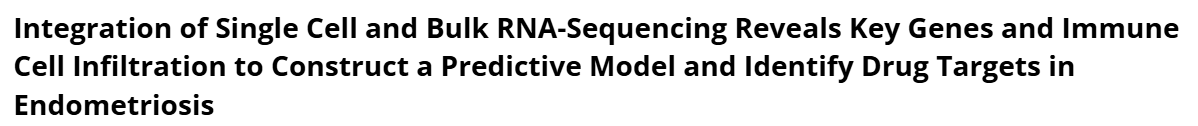

| **项目** | **内容** |
|:---|:---|
| **数据来源** | - scRNA-seq数据：从GEO数据库下载GSE179640和GSE213216，包含增殖期子宫内膜组织的单细胞数据，共110个样本（健康对照3个，子宫内膜异位症患者8个）。<br>- bulk RNA-seq数据：从GEO数据库下载GSE25628和GSE153739，包含增殖期子宫内膜组织的批量RNA测序数据，共21个样本（健康对照9个，子宫内膜异位症患者12个）。 |
| **数据整合策略** | - **单细胞数据处理**：<br>1. 使用Seurat R包进行数据整合，通过锚点技术整合不同样本。<br>2. 过滤掉线粒体含量>20%的细胞，以及基因数<200或>6000的细胞。<br>3. 使用线性回归模型对核心细胞的基因表达进行标准化，并通过ANOVA分析筛选出2000个高变基因。<br>4. 使用PCA和Harmony算法进行批次效应校正，UMAP算法进行降维分析。<br>5. 使用SingleR包结合参考数据库（Human Primary Cell Atlas、PanglaoDB等）进行细胞类型注释，并手动校正注释结果。<br>- **批量RNA-seq数据处理**：<br>1. 使用limma工具进行差异表达基因（DEGs）分析，筛选出P值<0.05且|log2FC|>1的基因。<br>2. 生成火山图和热图展示DEGs。<br>- **数据整合**：<br>1. 将bulk RNA-seq中的DEGs与scRNA-seq中鉴定的间充质细胞基因集取交集，作为后续分析的候选基因集。<br>2. 使用LASSO回归分析从候选基因中筛选关键基因，构建疾病风险预测模型。 |
| **计算工具** | - **R包**：<br>Seurat（单细胞数据整合与降维分析）<br>SingleR（细胞类型注释）<br>Harmony（批次效应校正）<br>limma（批量RNA-seq差异表达分析）<br>glmnet（LASSO回归分析）<br>survROC（ROC曲线绘制）<br>clusterProfiler（基因集富集分析）<br>- **其他工具**：<br>UMAP算法（降维分析）<br>CIBERSORT（免疫细胞浸润分析）<br>ssGSEA（单样本基因集富集分析）<br>miRcode（miRNA网络分析）<br>RcisTarget（转录因子预测）<br>Connectivity Map（药物靶点预测） |
| **应用场景** | - **细胞类型注释与贡献分析**：<br>通过scRNA-seq数据，鉴定出8种细胞类型（B细胞/浆细胞、内皮细胞、上皮细胞、肥大细胞、间充质细胞、髓系细胞、平滑肌细胞、T/NKT细胞），并计算它们对子宫内膜异位症的贡献，发现间充质细胞是主要贡献细胞类型。<br>- **疾病风险预测模型构建**：<br>基于LASSO回归分析，从候选基因中筛选出8个关键基因（SYNE2、TXN、NUPR1、CTSK、GSN、MGP、IER2、CXCL12），构建疾病风险预测模型，模型在训练集和验证集上均表现出良好的预测性能（AUC分别为1.00和0.8125）。<br>- **免疫细胞浸润分析**：<br>使用CIBERSORT和ssGSEA算法分析子宫内膜组织中免疫细胞的浸润情况，发现子宫内膜异位症患者中CD8+ T细胞和单核细胞显著增加，记忆B细胞显著减少。<br>- **基因集富集分析与通路分析**：<br>通过GSEA和GSVA分析，研究关键基因在子宫内膜异位症中的功能通路差异，揭示了这些基因可能参与的信号通路，如钙信号通路、MAPK信号通路、cGMP-PKG信号通路等。<br>- **miRNA网络与转录因子调控网络分析**：<br>构建关键基因与miRNA的相互作用网络，预测关键基因的转录因子，揭示基因表达的调控机制。<br>- **药物靶点预测**：<br>利用Connectivity Map数据库，预测可能对子宫内膜异位症有治疗效果的药物（如Retinol、Orantinib、Piperacillin、NECA），为潜在治疗策略提供依据。 |

（3）https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2022.898925/full

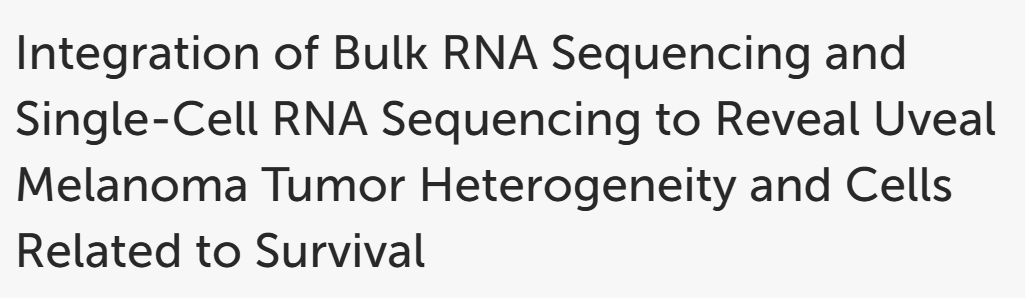

| **项目**       | **内容**                                                                 |
|:---------------|:-------------------------------------------------------------------------|
| **数据来源**   | - bulk RNA-seq数据：从TCGA数据库（GSE22138队列）和GEO数据库下载<br>- scRNA-seq数据：从GEO数据库（GSE138433）下载 |
| **整合策略**   | - 基于免疫相关基因集的共识聚类（Consensus Clustering）将UM患者分为两种免疫亚型（IS1和IS2）<br>- 利用scRNA-seq数据识别UM中的细胞异质性，确定与预后相关的细胞簇<br>- 结合bulk RNA-seq数据中的免疫亚型特征与scRNA-seq数据中的细胞簇特征，分析它们之间的关联 |
| **计算工具**   | - **R软件**：用于所有统计分析，包括数据预处理、差异表达分析、生存分析等<br>- **IOBR包**：计算免疫基因集的富集分数<br>- **ConsensusClusterPlus包**：进行共识聚类分析<br>- **Seurat包**：处理和分析scRNA-seq数据，包括质量控制、标准化、降维、细胞聚类等<br>- **Monocle 2**：构建单细胞伪时间轨迹，分析细胞分化轨迹<br>- **SCENIC**：分析单细胞转录因子调控网络<br>- **Limma包**：用于差异表达分析<br>- **CIBERSORT**：评估免疫细胞浸润比例<br>- **ESTIMATE算法**：估计免疫和基质细胞浸润<br>- **Hmisc包**：用于mRNA-lncRNA相互作用网络分析<br>- **starBase V3.0数据库**：获取miRNA-mRNA和miRNA-lncRNA相互作用数据 |
| **应用场景**   | - **免疫亚型划分**：基于免疫基因集的富集分数，将UM患者分为两种免疫亚型（IS1和IS2），并分析其与预后的关系<br>- **细胞异质性分析**：通过scRNA-seq数据识别UM中的11个细胞簇，并确定其中5个与预后相关的细胞簇（C1、C4、C5、C8、C9）<br>- **细胞分化轨迹分析**：利用Monocle 2构建细胞伪时间轨迹，分析5个预后相关细胞簇的分化状态<br>- **转录因子调控网络分析**：通过SCENIC分析单细胞转录因子调控网络，揭示关键转录因子及其靶基因<br>- **mRNA-lncRNA相互作用网络构建**：基于miRNA-mRNA和miRNA-lncRNA相互作用数据，构建mRNA-lncRNA相互作用网络，筛选关键基因和lncRNA<br>- **预后标志物筛选**：结合免疫亚型特征和细胞簇特征，筛选与UM预后相关的标志物基因和细胞类型 |
| **数据分析流程** | 1. **数据预处理**：对bulk RNA-seq数据和scRNA-seq数据分别进行质量控制、标准化和归一化处理<br>2. **免疫亚型划分**：基于免疫基因集的富集分数，利用ConsensusClusterPlus进行共识聚类，将UM患者分为IS1和IS2<br>3. **scRNA-seq数据分析**：使用Seurat包进行细胞聚类，识别UM中的11个细胞簇，并通过差异表达分析确定与预后相关的细胞簇<br>4. **细胞分化轨迹分析**：利用Monocle 2构建细胞伪时间轨迹，分析预后相关细胞簇的分化状态<br>5. **转录因子调控网络分析**：通过SCENIC分析单细胞转录因子调控网络，揭示关键转录因子及其靶基因<br>6. **mRNA-lncRNA相互作用网络构建**：基于miRNA-mRNA和miRNA-lncRNA相互作用数据，构建mRNA-lncRNA相互作用网络，筛选关键基因和lncRNA<br>7. **预后相关性分析**：结合免疫亚型特征和细胞簇特征，分析其与UM预后的关系，筛选预后标志物 |

（4）https://www.sciencedirect.com/science/article/pii/S2405844023034217

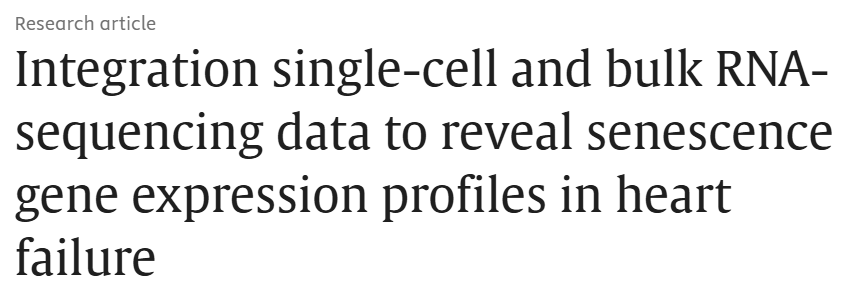

| **项目** | **内容** |
|:---|:---|
| **整合目的** | 通过整合scRNA-seq数据和bulk RNA-seq数据，揭示心力衰竭（HF）中衰老基因的表达特征，探索衰老基因在HF中的作用及其潜在的分子机制和治疗靶点。 |
| **数据来源** | <ul><li>scRNA-seq数据：GSE145154，包含191,225个细胞，来源于扩张型心肌病（DCM）和缺血性心肌病（ICM）患者的左心室和右心室。</li><li>Bulk RNA-seq数据：GSE141910，包含366个样本，其中200个HF样本和166个非HF样本。</li><li>衰老基因数据：从CellAge数据库下载。</li></ul> |
| **整合策略** | <ul><li>**细胞聚类与注释**：使用Seurat工具包对scRNA-seq数据进行细胞聚类分析，将细胞分为不同簇，并基于BlueprintEncodeData信息进行细胞类型注释。</li><li>**差异表达基因（DEG）分析**：在scRNA-seq数据中，使用FindMarkers函数识别细胞簇之间的差异表达基因；在bulk RNA-seq数据中，使用limma包分析HF与非HF样本之间的DEG。</li><li>**细胞活性评分**：基于AUCell包计算细胞的衰老基因活性评分，识别具有衰老基因活性的细胞。</li><li>**基因集交集分析**：通过UpSetR包绘制scRNA-seq中活性细胞类型的DEG、bulk数据DEG和衰老基因之间的交集，识别共同的衰老基因。</li><li>**功能富集分析**：对识别的DEG进行GO和KEGG富集分析，探索其生物学功能和通路。</li><li>**网络分析**：构建蛋白质-蛋白质相互作用（PPI）网络和ceRNA网络，分析衰老基因的调控网络。</li><li>**药物预测**：基于DGIdb数据库的基因-药物相互作用数据，寻找针对共同衰老基因的潜在靶向治疗药物。</li></ul> |
| **计算工具** | <ul><li>Seurat：用于单细胞数据的聚类和可视化分析。</li><li>FindMarkers（Seurat包）：用于识别差异表达基因。</li><li>AUCell：用于计算细胞活性评分。</li><li>UpSetR：用于绘制基因集交集。</li><li>limma：用于bulk RNA-seq数据的差异表达分析。</li><li>clusterProfiler：用于GO和KEGG富集分析。</li><li>STRING、Cytoscape：用于PPI网络构建和可视化。</li><li>cytoHubba（Cytoscape插件）：用于识别PPI网络中的关键节点。</li><li>MiRDB、TargetScan：用于预测miRNA靶基因，构建ceRNA网络。</li><li>DGIdb：用于基因-药物相互作用分析。</li></ul> |
| **应用场景** | <ul><li>揭示心力衰竭中不同细胞类型的衰老基因表达特征。</li><li>探索衰老基因在心力衰竭中的潜在作用机制。</li><li>识别潜在的治疗靶点和药物，为心力衰竭的治疗提供新的思路。</li></ul> |

（5）https://elifesciences.org/reviewed-preprints/106183

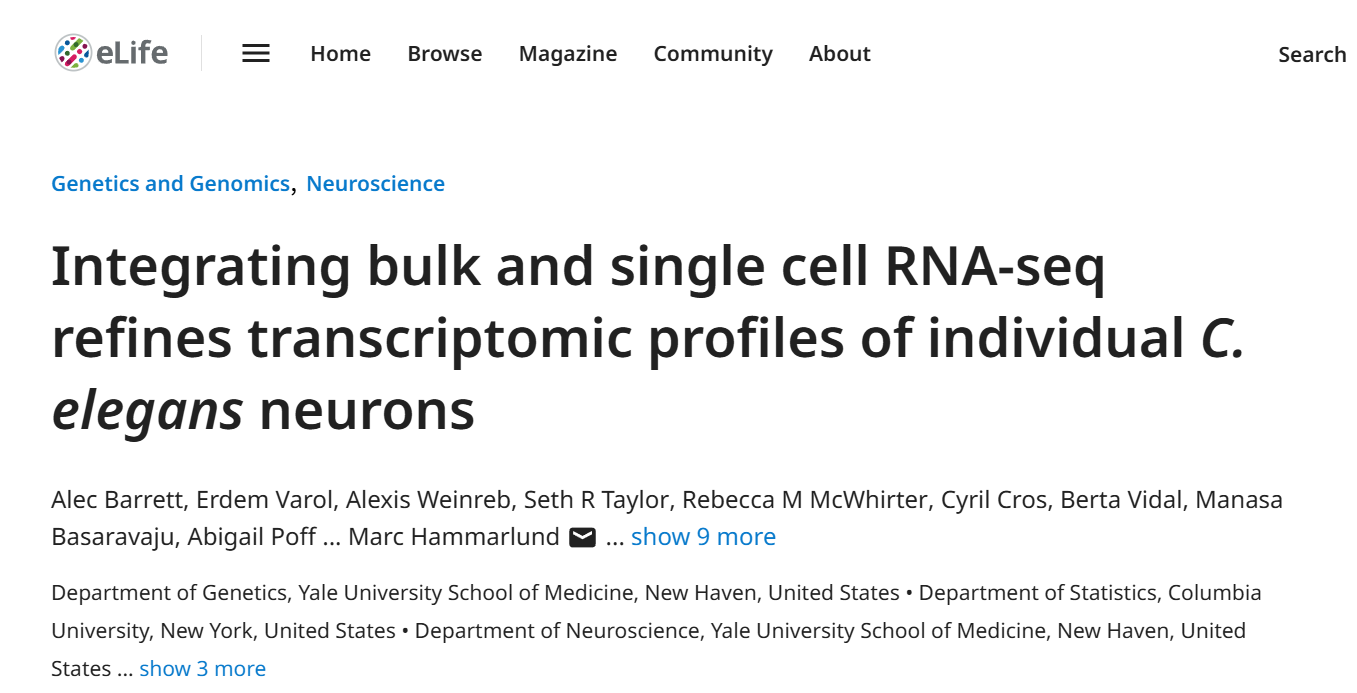

稍微涉及到点工具、算法层面的方法开发

| **项目** | **内容** |
|:---|:---|
| **整合目的** | 提高基因表达检测的准确性和灵敏度，弥补scRNA-seq数据在低表达基因和非编码RNA检测上的不足。 |
| **整合策略** | 1. **LittleBites算法**：通过迭代线性减法从bulk RNA-seq数据中去除污染，利用scRNA-seq数据作为参考，结合已知的基因表达信息（“ground truth”基因），逐步减去非目标细胞类型的表达信号，最终提高bulk RNA-seq数据的纯度和准确性。 <br> 2. **几何平均数整合**：将bulk RNA-seq数据和scRNA-seq数据（通过scProp2Count方法转换后的比例数据）进行几何平均数计算，生成整合数据集，以结合两种数据的优势。 |
| **计算工具** | 1. **LittleBites**：用于从bulk RNA-seq数据中去除污染的算法，代码可在GitHub上找到（https://github.com/alecbarrett/LittleBites）。 <br> 2. **scProp2Count**：用于将scRNA-seq的比例数据转换为计数数据的工具，代码可在GitHub上找到（https://github.com/alecbarrett/Prop2Count）。 <br> 3. **edgeR**：用于差异表达分析的R包。 <br> 4. **FASTQC**：用于测序数据质量控制的工具。 <br> 5. **STAR**：用于将测序读段比对到参考基因组的工具。 <br> 6. **featureCounts**：用于生成基因计数矩阵的工具。 <br> 7. **UMI-tools**：用于去除重复读段的工具。 <br> 8. **bMIND和ENIGMA**：用于从bulk RNA-seq数据中提取细胞类型特异性表达的工具，用于与LittleBites算法进行性能比较。 |
| **应用场景** | 1. **提高基因检测准确性**：整合后的数据集在检测低表达基因和非编码RNA方面表现出色，能够更准确地反映基因表达情况。 <br> 2. **补充scRNA-seq数据**：对于在scRNA-seq数据中未检测到的基因（如低表达基因和非编码RNA），bulk RNA-seq数据提供了补充信息。 <br> 3. **研究神经元基因表达模式**：通过整合数据，能够更全面地分析C. elegans神经系统中不同神经元类型的基因表达模式，包括神经元特异性基因和泛神经元基因。 <br> 4. **探索基因表达与神经元功能的关联**：为研究基因表达如何影响神经元的形态、功能和连接性提供了更准确的数据基础。 |
| **数据分析流程** | 1. **bulk RNA-seq数据生成**：通过流式细胞分选（FACS）技术分离特定神经元类型，进行bulk RNA-seq测序。 <br> 2. **scRNA-seq数据准备**：使用已有的scRNA-seq数据，通过scProp2Count方法将比例数据转换为计数数据。 <br> 3. **数据预处理**：包括质量控制、比对到参考基因组、生成基因计数矩阵等。 <br> 4. **去除污染**：使用LittleBites算法对bulk RNA-seq数据进行去污染处理。 <br> 5. **数据整合**：将去污染后的bulk RNA-seq数据与scRNA-seq数据进行几何平均数整合。 <br> 6. **结果评估**：通过与“ground truth”基因表达数据进行比较，评估整合数据集的准确性。 <br> 7. **下游分析**：利用整合数据集进行差异表达分析、基因功能注释、非编码RNA分析等。 |

（6）https://pmc.ncbi.nlm.nih.gov/articles/PMC11025768/

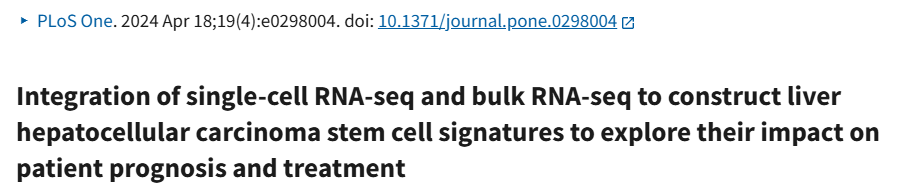

| **项目** | **内容** |
|:---|:---|
| **数据整合策略** | 1. **多维度评估细胞干性**：通过CytoTRACE算法计算scRNA-seq数据中的细胞干性评分（CytoTRACE score），并通过One Class Linear Regression（OCLR）算法计算bulk RNA-seq数据中的mRNAsi（mRNA表达基础的干性指数）。2. **基因模块关联分析**：利用加权基因共表达网络分析（WGCNA）识别与mRNAsi相关的基因模块，并结合CytoTRACE评分相关基因进行筛选。3. **生存分析与风险模型构建**：基于与干性评分相关的基因，通过Cox回归分析构建预后风险模型，并在不同数据集中验证模型的可靠性。 |
| **数据分析流程** | 1. **数据预处理**：对scRNA-seq数据进行质量控制、标准化和降维处理；对bulk RNA-seq数据进行表达值转换和格式化。2. **细胞干性评估**：分别计算scRNA-seq和bulk RNA-seq数据中的细胞干性评分（CytoTRACE score和mRNAsi）。3. **基因共表达网络分析**：利用WGCNA识别与mRNAsi相关的基因模块。4. **生存分析与风险模型构建**：通过Cox回归分析筛选与预后相关的基因，并构建风险模型。5. **免疫浸润与治疗响应分析**：评估不同风险组的免疫浸润水平和免疫治疗响应。 |
| **计算工具** | 1. **R语言及其包**：使用R语言进行数据分析，包括Seurat包用于scRNA-seq数据预处理和细胞聚类；WGCNA包用于基因共表达网络分析；glmnet包用于LASSO回归分析；rms包用于构建Nomogram。2. **Python及其工具**：未明确提及Python工具，但可能用于部分数据分析流程。3. **其他工具**：使用TIDE算法评估免疫治疗响应；pRRophetic包评估化疗药物敏感性。 |
| **应用场景** | 1. **预后风险评估**：通过构建的风险模型预测肝细胞癌（LIHC）患者的预后，区分高风险和低风险患者。2. **免疫治疗响应预测**：评估不同风险组患者的免疫治疗响应潜力，为个性化免疫治疗提供依据。3. **化疗药物敏感性预测**：预测不同风险组患者对常见化疗药物的敏感性，指导化疗方案选择。4. **免疫浸润分析**：评估肿瘤微环境中的免疫细胞浸润水平，揭示高风险和低风险组的免疫特征差异。 |

（7）https://febs.onlinelibrary.wiley.com/doi/full/10.1002/1878-0261.13804

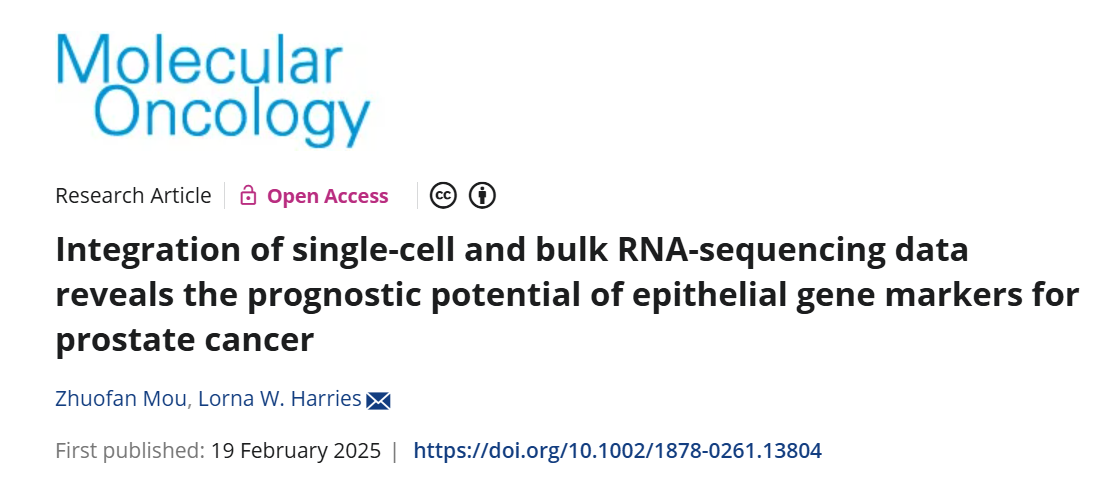

| **项目** | **内容** |
| --- | --- |
| **数据整合目标** | 整合scRNA-seq和bulk RNA-seq数据，以全面评估前列腺癌（PCa）中基因表达的变化，并开发用于预测生化复发无生存（biochemical recurrence-free survival，BCRFS）的预后标志物。 |
| **数据来源** | - **Bulk RNA-seq数据**：从TCGA-PRAD、GSE21034、GSE70768、E-MTAB-6128和DKFZ等五个大型PCa队列中获取。<br>- **scRNA-seq数据**：从GSE193337数据集中获取，包含4例前列腺癌患者的肿瘤组织样本。 |
| **整合策略** | 1. **基因表达一致性分析**：通过meta分析，识别在多个bulk RNA-seq数据集中一致上调的PCa相关基因。<br>2. **单细胞水平验证**：在scRNA-seq数据中识别细胞类型特异性的标记基因，并与一致性上调的基因进行对比，确定主要来自上皮细胞的标记基因。<br>3. **机器学习模型开发**：利用多种机器学习算法，基于细胞类型特异性的标记基因开发预后标志物，并在多个队列中验证其预测能力。 |
| **计算工具** | - **R包GeneMeta**：用于meta分析，计算每个基因在数据集内的效应大小（Hedges' g）及合并效应大小。<br>- **Seurat**：用于scRNA-seq数据的预处理、降维和细胞聚类分析。<br>- **SingleR**：用于细胞类型注释。<br>- **FindAllMarkers**：用于识别细胞类型特异性标记基因。<br>- **glmnet、randomForestSRC等**：用于实现弹性网络（Enet）、随机生存森林（RSF）等97种机器学习算法的建模和验证。 |
| **应用场景** | 1. **预后标志物开发**：开发了一个基于11个上皮细胞标记基因的预后标志物，用于预测前列腺癌患者的BCRFS，并在多个独立队列中验证其有效性。<br>2. **风险分层**：将患者分为高风险和低风险组，高风险患者显示出更差的生存结果和不同的免疫细胞群体。<br>3. **非侵入性生物标志物探索**：分析外周血数据，评估部分标志物基因作为局部癌症患者放疗反应的生物标志物潜力，并用于去势抵抗性前列腺癌患者的总生存分层。 |
| **结果验证** | - 在五个独立的PCa队列中，通过Kaplan-Meier生存分析和ROC分析验证了标志物的预测能力。<br>- 与68种已发表的PCa基因标志物进行比较，该标志物在多个队列中表现出优越的预测性能。<br>- 在外周血数据中，部分标志物基因显示出作为非侵入性生物标志物的潜力，能够有效分层局部癌症患者的放疗反应和去势抵抗性患者的总生存。 |